In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nltk
import re
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow import keras
from torch_geometric.data import HeteroData
import torch
import torch_geometric.transforms as T
from sklearn.preprocessing import RobustScaler
import itertools

#### Read csv file

In [2]:

file_path = r"ottawashooting-all-rnr-threads.csv"
df = pd.read_csv(file_path)


In [3]:
df.head()

,Unnamed: 0,id,text,time,location,followers,user_id,favorite_count,retweet_count,verified,rumour,reply_id,reply_text,reply_time,reply_location,reply_followers,reply_user_id,reply_verified
0,0,524922507380670464,#Ottawa police confirm shooting at War Memoria...,Wed Oct 22 13:57:33 +0000 2014,Toronto,357541,19038934,23,248,True,1,524922753066221568,Ugh...please be safe RT@CBCAlerts: #Ottawa pol...,Wed Oct 22 13:58:31 +0000 2014,"Fredericton, New Brunswick",2014,522403192,False
1,1,524922507380670464,#Ottawa police confirm shooting at War Memoria...,Wed Oct 22 13:57:33 +0000 2014,Toronto,357541,19038934,23,248,True,1,524923072852529152,“@CBCAlerts: #Ottawa police confirm shooting a...,Wed Oct 22 13:59:47 +0000 2014,NaN,2045,516234551,False
2,2,524922507380670464,#Ottawa police confirm shooting at War Memoria...,Wed Oct 22 13:57:33 +0000 2014,Toronto,357541,19038934,23,248,True,1,524924695356125184,RT“@CBCAlerts: #Ottawa police confirm shooting...,Wed Oct 22 14:06:14 +0000 2014,Paris-Brest,2192,312024587,False
3,3,524922507380670464,#Ottawa police confirm shooting at War Memoria...,Wed Oct 22 13:57:33 +0000 2014,Toronto,357541,19038934,23,248,True,1,524925473986736128,"""@CBCAlerts: #Ottawa police confirm shooting a...",Wed Oct 22 14:09:20 +0000 2014,"Not Los Angeles, Not New York.",1427,15992943,False
4,4,524922507380670464,#Ottawa police confirm shooting at War Memoria...,Wed Oct 22 13:57:33 +0000 2014,Toronto,357541,19038934,23,248,True,1,524928726497525761,@CBCAlerts,Wed Oct 22 14:22:15 +0000 2014,NaN,1,443754749,False


In [4]:
df.time = pd.to_datetime(df.time)
df.reply_time = pd.to_datetime(df.reply_time)

df['time_diff']=(df.reply_time - df.time).dt.total_seconds()/60
df['reply_number'] = df.groupby('id')['time_diff'].rank(method='dense')

/tmp/ipykernel_28766/2253231603.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.time = pd.to_datetime(df.time)
/tmp/ipykernel_28766/2253231603.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.reply_time = pd.to_datetime(df.reply_time)


In [5]:
df_posts = df[['id','text','followers','favorite_count','retweet_count','verified',\
  'rumour','user_id']].drop_duplicates().merge(df.groupby(['id']).agg(replies=(\
  'time_diff','count'),first_time_diff=('time_diff','first')).reset_index(),\
  on="id",how="left")

#### Why glove embbedigns

In [6]:

nltk.download('stopwords')

english_stopwords = nltk.corpus.stopwords.words('english')


def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt


def clean_text(
    string: str,
    punctuations=r'''!()-[]{};:'"\,<>./?@#$%^&*_~''',
    stop_words=english_stopwords) -> str:
    """
    A method to clean text
    """

    string = re.sub(r'https?://\S+|www\.\S+', '', string)

    string = re.sub(r'<.*?>', '', string)
    
    for x in string.lower():
        if x in punctuations:
            string = string.replace(x, "")

    string = string.lower()
   
    string = ' '.join([word for word in string.split() if word not in stop_words])

    string = re.sub(r'\s+', ' ', string).strip()

    return string

def cosine_similarities(embedding_matrix, word_index, word):
    idx = word_index.get(word)
    if idx is None:
        return None
    vector = embedding_matrix[idx].reshape(1, -1)
    similarities = cosine_similarity(vector, embedding_matrix)
    return similarities[0]


def get_embeddings(sequence, embedding_matrix):
    embeddings = []
    for idx in sequence:
        embeddings.append(embedding_matrix[idx])
    return np.array(embeddings)

def embedding_vocab(filepath, word_index,embedding_dim):
    vocab_size = len(word_index) + 1

    embedding_matrix_vocab = np.zeros((vocab_size,
                                       embedding_dim))

    with open(filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix_vocab[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix_vocab

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
df_posts['clean_text'] = np.vectorize(remove_pattern)(df_posts['text'], "@[\w]*")
df_posts['clean_text'] = df_posts['clean_text'].str.replace("[^a-zA-Z#]", " ").apply(clean_text)

df['clean_reply_text'] = np.vectorize(remove_pattern)(df['reply_text'], "@[\w]*")
df['clean_reply_text'] = df['clean_reply_text'].str.replace("[^a-zA-Z#]", " ").apply(clean_text)

<>:1: SyntaxWarning: invalid escape sequence '\w'
<>:4: SyntaxWarning: invalid escape sequence '\w'
<>:1: SyntaxWarning: invalid escape sequence '\w'
<>:4: SyntaxWarning: invalid escape sequence '\w'
/tmp/ipykernel_28766/4230305453.py:1: SyntaxWarning: invalid escape sequence '\w'
  df_posts['clean_text'] = np.vectorize(remove_pattern)(df_posts['text'], "@[\w]*")
/tmp/ipykernel_28766/4230305453.py:4: SyntaxWarning: invalid escape sequence '\w'
  df['clean_reply_text'] = np.vectorize(remove_pattern)(df['reply_text'], "@[\w]*")


#### Source tweet embeddings

In [8]:
tokenizer = keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df_posts['clean_text'])

In [9]:
embedding_dim = 100
embedding_matrix_vocab = embedding_vocab(
    'glove.6B.100d.txt', tokenizer.word_index,
embedding_dim)

In [10]:

sequences = tokenizer.texts_to_sequences(df_posts['clean_text'])

max_sequence_length = max(len(seq) for seq in sequences)
padded_sequences = keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_sequence_length)

df_posts['embeddings'] = [get_embeddings(seq, embedding_matrix_vocab) for seq in sequences]

In [11]:
array_avg = []
for i in df_posts.embeddings:
  array_avg.append(np.mean(i,axis=0))
df_posts['embeddings_avg'] = array_avg

In [12]:
similarities = cosine_similarities(embedding_matrix_vocab, tokenizer.word_index, 'soldier')
similar_indices = similarities.argsort()[::-1]
for idx in similar_indices[1:6]:  # excluding the word itself
    word = tokenizer.index_word[idx]
    print(word)

soldiers
wounded
army
killed
dead


In [13]:
similarities = cosine_similarities(embedding_matrix_vocab, tokenizer.word_index, 'terrorism')
similar_indices = similarities.argsort()[::-1]
for idx in similar_indices[1:6]:  # excluding the word itself
    word = tokenizer.index_word[idx]
    print(word)

terror
terrorist
terrorists
threats
attacks


#### Reply embeddings

In [14]:
tokenizer =  keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df['clean_reply_text'])

In [15]:
embedding_matrix_vocab = embedding_vocab(
    'glove.6B.100d.txt', tokenizer.word_index,
embedding_dim)

In [16]:
sequences = tokenizer.texts_to_sequences(df['clean_reply_text'])

max_sequence_length = max(len(seq) for seq in sequences)
padded_sequences = keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_sequence_length)

df['reply_embeddings'] = [get_embeddings(seq, embedding_matrix_vocab) for seq in sequences]

In [17]:
array_avg = []
for i in df.reply_embeddings:
  array_avg.append(np.mean(i,axis=0))
df['reply_embeddings_avg'] = array_avg

/home/codespace/miniconda3/envs/mastering/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/codespace/miniconda3/envs/mastering/lib/python3.12/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [18]:
df['reply_embeddings_avg'] = df['reply_embeddings_avg'].apply(lambda x: x if isinstance(x, np.ndarray) else np.zeros(100))
df_replies = df

#### Creat Graph

####  One Hot encoding

In [19]:
df_posts['verified'] = df_posts['verified'].astype('str').str.\
             replace(' ', '').replace('True', '1').replace('False', '0')\
             .astype('int64')

df_posts = pd.concat([df_posts, pd.get_dummies(\
                          df_posts["verified"],dtype=int)], axis=1, join='inner')
df_posts.drop(["verified"], axis=1, inplace=True)
df_posts.rename(columns={1:'verified',0:'no_verified'},inplace=True)

In [20]:

df_replies['reply_verified'] = df_replies['reply_verified'].astype('str').str.\
             replace(' ', '').replace('True', '1').replace('False', '0')\
             .astype('int64')

df_replies = pd.concat([df_replies, pd.get_dummies(\
                          df_replies["reply_verified"],dtype=int)], axis=1, join='inner')
df_replies.drop(["reply_verified"], axis=1, inplace=True)
df_replies.rename(columns={1:'reply_verified',0:'reply_no_verified'},inplace=True)

#### Mapping post ids

In [21]:
unique_values = df_posts['id'].unique()

value_to_id = {value: i for i, value in enumerate(unique_values)}

post_map  = value_to_id

post_features = df_posts[["followers", "favorite_count","retweet_count","no_verified","verified",\
                          "first_time_diff"]]


#### Scaler

In [22]:
scaler = RobustScaler()

scaled_features = scaler.fit_transform(post_features[['followers', 'favorite_count', 'retweet_count', 'first_time_diff']])

scaled_data = pd.DataFrame(scaled_features, columns=['followers', 'favorite_count', 'retweet_count', 'first_time_diff'])

scaled_data['no_verified'] = post_features['no_verified']
scaled_data['verified'] = post_features['verified']
post_features = scaled_data

#### Tweet features

In [23]:
embeddings_avg = []
for embeddings in df_posts['embeddings_avg']:
  embeddings_avg.append(embeddings)
x1 = np.concatenate((post_features.to_numpy(),np.array(embeddings_avg)),axis=1)

x1.shape 

(857, 106)

#### Mapping user id's

In [24]:
retweets_node_features = df_replies[["reply_followers", "reply_no_verified", "reply_verified","reply_user_id","time_diff"]]

unique_values = retweets_node_features['reply_user_id'].unique()

value_to_id = {value: i for i, value in enumerate(unique_values)}

retweets_id_mapping  = value_to_id

retweets_node_features = retweets_node_features[["reply_followers", "reply_no_verified", "reply_verified","time_diff"]]


#### Scaler

In [25]:

scaler = RobustScaler()

scaled_features = scaler.fit_transform(retweets_node_features[['reply_followers','time_diff']])

scaled_data = pd.DataFrame(scaled_features, columns=['reply_followers','time_diff'])

scaled_data['reply_no_verified'] = retweets_node_features['reply_no_verified']
scaled_data['reply_verified'] = retweets_node_features['reply_verified']
retweets_node_features = scaled_data


####  User features

In [26]:
x2 = retweets_node_features.to_numpy()
x2.shape # [num_movie_nodes x movie_node_feature_dim]

(7387, 4)

#### Labels

In [27]:

labels = df_posts.rumour
y = labels.to_numpy()
y.shape

(857,)

#### Edges

In [28]:


df_replies["id"] = df_replies['id'].map(post_map).astype(int)


df_replies["reply_user_id"] = df_replies["reply_user_id"].map(retweets_id_mapping)#.astype(int)

In [29]:
edge_index = df_replies[["id", "reply_user_id"]].values.transpose()
edge_index # [2 x num_edges]

array([[   0,    0,    0, ...,  856,  856,  856],
       [   0,    1,    2, ..., 5393, 6207, 6208]])

#### Train test split

In [30]:
num_rows = x1.shape[0]

train_proportion = 0.70
val_proportion = 0.15
test_proportion = 0.15

indices = np.arange(num_rows)
np.random.shuffle(indices)

train_end = int(train_proportion * num_rows)
val_end = train_end + int(val_proportion * num_rows)

train_indices = indices[:train_end]
val_indices = indices[train_end:val_end]
test_indices = indices[val_end:]

train_mask = np.zeros(num_rows, dtype=bool)
val_mask = np.zeros(num_rows, dtype=bool)
test_mask = np.zeros(num_rows, dtype=bool)

train_mask[train_indices] = True
val_mask[val_indices] = True
test_mask[test_indices] = True


#### Initialize the HeteroData object

In [31]:
data = HeteroData()

data['id'].x = torch.tensor(x1,dtype=torch.float32) 
data['id'].y = torch.from_numpy(y) 
data['id'].train_mask = torch.tensor(train_mask)  # Training mask
data['id'].val_mask =torch.tensor(val_mask)  # Validation mask
data['id'].test_mask = torch.tensor(test_mask)  # Test mask

data['reply_user_id'].x = torch.tensor(x2,dtype=torch.float32) #torch.float32

data['id', 'retweet', 'reply_user_id'].edge_index = torch.from_numpy(edge_index.reshape(2,len(x2)))
data = T.ToUndirected()(data)
print(data)


HeteroData(
  id={
    x=[857, 106],
    y=[857],
    train_mask=[857],
    val_mask=[857],
    test_mask=[857],
  },
  reply_user_id={ x=[7387, 4] },
  (id, retweet, reply_user_id)={ edge_index=[2, 7387] },
  (reply_user_id, rev_retweet, id)={ edge_index=[2, 7387] }
)


In [43]:
import pandas as pd
import networkx as nx
import plotly.graph_objects as go

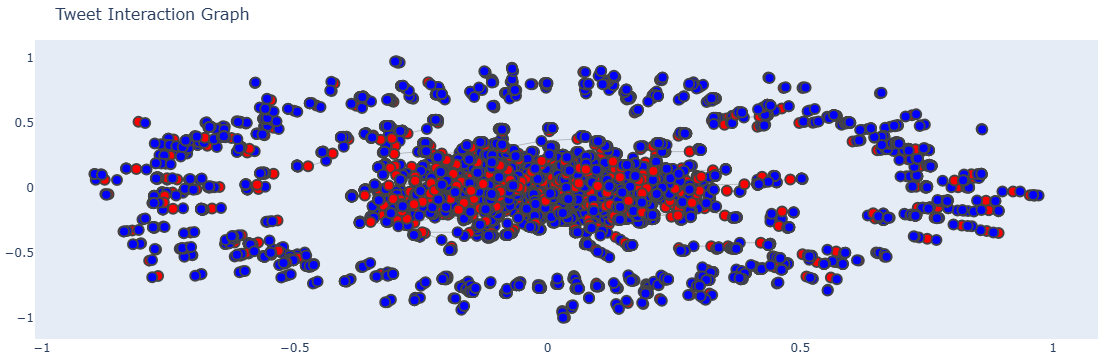

In [47]:

G = nx.Graph()
for _, row in df.iterrows():
    G.add_edge(row['id'], row['reply_user_id'])

node_types = {'id': 'red', 'reply_user_id': 'blue'}

node_colors = {}
for node in G.nodes():
    if node in df['id'].values:
        node_colors[node] = node_types['id']
    elif node in df['reply_user_id'].values:
        node_colors[node] = node_types['reply_user_id']

pos = nx.spring_layout(G)

edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

node_x = []
node_y = []
node_color = []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_color.append(node_colors[node])

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='none',
    marker=dict(
        showscale=False,
        colorscale='YlGnBu',
        color=node_color,
        size=10,
        line_width=2))

fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title='Tweet Interaction Graph',
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20, l=5, r=5, t=40),
                    annotations=[dict(
                        text="",
                        showarrow=False,
                        xref="paper", yref="paper")],
                    xaxis=dict(showgrid=False, zeroline=False),
                    yaxis=dict(showgrid=False, zeroline=False)))

fig.show()

In [32]:
# Group by 'id' and aggregate 'user_id' into a list of unique users
grouped_df = df.groupby('id')['reply_user_id'].apply(lambda x: list(set(x)))

# Function to create co-occurrence dictionary for n-sized combinations
def create_co_occurrence(n):
    co_occurrence = {}

    # Iterate over each post and its unique users
    for users in grouped_df:
        # Create all unique n-sized combinations of users
        for combo in itertools.combinations(sorted(users), n):
            # Increment the count for each combination
            if combo in co_occurrence:
                co_occurrence[combo] += 1
            else:
                co_occurrence[combo] = 1

    # Convert the dictionary to a DataFrame
    co_occurrence_df = pd.DataFrame(
        [(list(combo), count) for combo, count in co_occurrence.items()],
        columns=['user_combination', 'count']
    )

    return co_occurrence_df

# Function to find the combinations with the highest count
def find_highest_combinations(co_occurrence_df):
    # Find the maximum count
    max_count = co_occurrence_df['count'].max()

    # Get the combinations with the highest count
    most_frequent_combinations = co_occurrence_df[co_occurrence_df['count'] == max_count]

    return most_frequent_combinations


In [36]:
# Example usage for 2, 3, and 4 users

n = 3
co_occurrence_df = create_co_occurrence(n)
most_frequent_combinations = find_highest_combinations(co_occurrence_df)
most_frequent_combinations

,user_combination,count
9282,"[21923301, 999907196, 1246812014]",2
31430,"[48310336, 457481692, 1273480106]",2
79028,"[26759726, 545670629, 853270471]",2
133679,"[500618656, 1001874828, 2390675047]",2


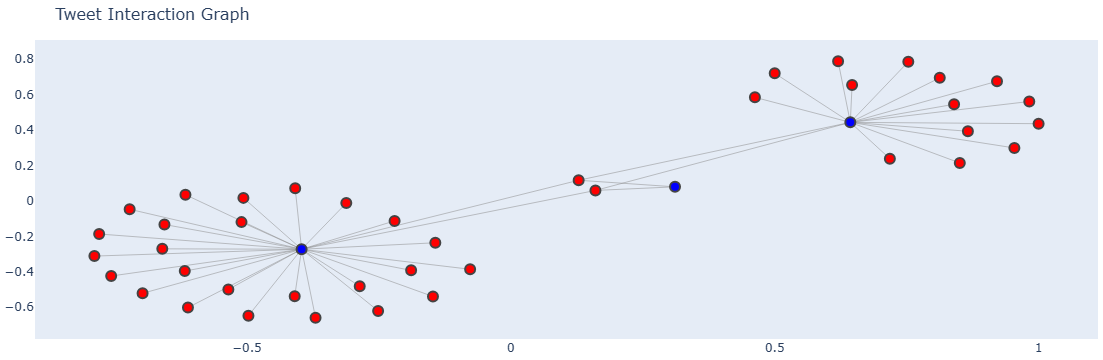

In [48]:
# Create the graph
reply_user_ids = most_frequent_combinations['user_combination'].values[0]

G = nx.Graph()
for _, row in df[df.reply_user_id.isin(reply_user_ids)].iterrows():
    G.add_edge(row['id'], row['reply_user_id'])

# Determine unique node types for coloring
node_types = {'id': 'red', 'reply_user_id': 'blue'}

# Initialize node colors
node_colors = {}
for node in G.nodes():
    if node in df['id'].values:
        node_colors[node] = node_types['id']
    elif node in df['reply_user_id'].values:
        node_colors[node] = node_types['reply_user_id']

# Extract node positions using a layout
pos = nx.spring_layout(G)

# Extract edges and their positions
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

# Extract node positions and colors
node_x = []
node_y = []
node_color = []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_color.append(node_colors[node])

# Create edge trace
edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

# Create node trace
node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='none',
    marker=dict(
        showscale=False,
        colorscale='YlGnBu',
        color=node_color,
        size=10,
        line_width=2))

# Create the figure
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title='Tweet Interaction Graph',
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20, l=5, r=5, t=40),
                    annotations=[dict(
                        text="",
                        showarrow=False,
                        xref="paper", yref="paper")],
                    xaxis=dict(showgrid=False, zeroline=False),
                    yaxis=dict(showgrid=False, zeroline=False)))

# Show the figure
fig.show()